<a href="https://colab.research.google.com/github/Samuel-CHLam/activation_sparsity/blob/master/Deep_Learning_Simulation_WeekF08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.integrate
import warnings
from scipy.stats import norm, multivariate_normal
from tqdm import tqdm

# Week Michaelmas 08 - Exploring the length and correlation map (Hard Thresholding)
In this week, we would like to explore the length and correlation maps for deep neural network with soft thresholding activation. Recall that a soft-thresholding activation with parameter $\tau > 0$ takes the form
$$\phi(z) = \phi^{\mathsf{hard}}_\tau(z) = z\mathbb{I}_{\mathbb{R}\setminus[-\tau,\tau]}(z)$$

In [ ]:
# You may wish to set the default tau here.
tau = .5

In [ ]:
def hard_thresholding(x, tau=tau):
  return x * (K.abs(x) > tau)

def hard_thresholding_numpy(x, tau=tau):
  return x * (np.abs(x) > tau)

get_custom_objects().update({'custom_activation': Activation(hard_thresholding)})

# Part 1. Observing the length map
The length map is given by
$$V_\phi(q) = \sigma^2_w \int_\mathbb{R} (\phi(\sqrt{q} z))^2 \gamma(dz) + \sigma^2_b.$$

There are three ways to observe the length map, and compute the equilibrium points:
- By numerically compute the integral
- By analytically compute the integral (in terms of the CDF of a normal density).
- By iterating over a neural network.

**Task.** Let us build a function which compute the length map numerically.

In [ ]:
# Numerical computation
def normal(z):
  return (1/np.sqrt(2*np.pi))*np.exp(-(z**2)/2)

def integrand(z,q,tau=tau):
  return normal(z)*(hard_thresholding_numpy(np.sqrt(q)*z, tau=tau)**2)

def length_map_numerical(q,sw,sb,tau=tau):
  inter_q, _ = sp.integrate.quad(lambda z: integrand(z, q, tau=tau), -np.inf, np.inf)
  return (sw**2)*inter_q + sb**2

**Task.** Let us build a function which compute the length map using the CDF of a standard normal. The formula is given by 
$$V_\phi(q) = 2q\sigma^2_w \left(\frac{\tau}{\sqrt{2\pi q}} \exp\left(-\frac{\tau^2}{2q}\right) + \tilde{\Phi}\left(\frac{\tau}{\sqrt{q}}\right)\right) + \sigma^2_b.$$
where $\phi$ is the normal density, $\Phi(z)$ (called as `norm.cdf`) being the standard normal CDF and and $\tilde{\Phi}(z) = 1 - \Phi(z)$ (called as `norm.sf`).

In [ ]:
# Analytical computation
def length_map_analytical(q,sw,sb,tau=tau):
  ratio = tau/np.sqrt(q)
  inter_q = q * (ratio * normal(ratio) + norm.sf(ratio))
  return 2*(sw**2) * inter_q + sb**2

**Task:** Let's make sure the two functions are consistent with each other. Here we choose $\sigma_w = 1$ and $\sigma_b = .3$.

In [ ]:
tau, sw, sb = 0.5, 1., 0.3
x_eval = np.linspace(0.01,1,500)
y_numerical = [length_map_numerical(q, sw=1., sb=0.3, tau=tau) for q in x_eval]
y_analytical = length_map_analytical(x_eval, sw=1., sb=0.3, tau=tau)

1

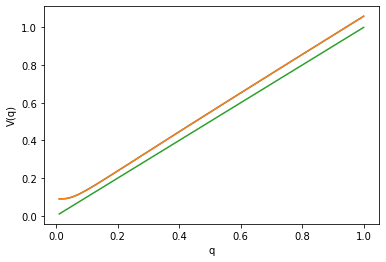

In [ ]:
plt.plot(x_eval, y_numerical, label="numerical")
plt.plot(x_eval, y_analytical, label="analytical")
plt.plot(x_eval, x_eval, label="identity")
plt.xlabel("q")
plt.ylabel("V(q)")
1

# print([length_map_numerical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.01,10,100)])
# print([length_map_analytical(q, sw=2.5, sb=0.3, tau=tau) for q in np.linspace(0.01,10,100)])

**Task:** Let's try simulate various iterations of the length map.

In [ ]:
def compute_q_star(sw,sb,tau=tau,N=1000,mode="analytical",seed=None,max_steps=50,show_hist=False,clip=50,err_val=-5):
  x = np.random.normal(size=N)

  # use initial condition given in the paper
  q0 = (1/len(x))*np.dot(x,x)
  q1 = (sw**2)*q0 + sb**2 

  # storing the iterates
  qs = []
  qs.append(q0)
  qs.append(q1)

  #iterate to convergence within specified tolerance
  count = 0
  while (np.abs(qs[count+1]-qs[count]) > 1e-04).any() and count <= max_steps:
    if mode == "analytical":
      q1 = length_map_analytical(q1, sw=sw, sb=sb, tau=tau)

    if mode == "numerical":
      # only support scalar output
      q1 = length_map_numerical(q1, sw=sw, sb=sb, tau=tau)

    qs.append(q1)
    count+=1

  if show_hist:
    # only support scalar output
    plt.plot(qs)
    plt.xlabel('$\ell$')
    plt.ylabel('$q^\ell$')
    print(np.array(qs))

  q_final = qs[-1]
  print(type(q_final))

  if type(q_final) == np.ndarray:
    q_final[q_final > clip] = err_val
    # q_final[q_final < -0.1] = err_val
    return q_final
  else:
    if q_final > clip:
      return err_val
    else:
      return q_final

Note that the length map does not necessary converge, and even if it converges, it might not necessary converge to a positive values.

[0.94349352 1.03349352 1.09306526 1.15336213 1.21434326 1.27597103
 1.33821071 1.40103025 1.4644     1.52829251 1.59268233 1.65754581
 1.72286098 1.78860737 1.85476588 1.9213187  1.98824914 2.0555416
 2.12318144 2.19115492 2.25944914 2.32805192 2.39695183 2.46613806
 2.53560041 2.60532924 2.67531544 2.74555034 2.81602578 2.88673396
 2.9576675  3.02881938 3.10018292 3.17175175 3.24351981 3.3154813
 3.38763072 3.45996277 3.53247242 3.60515483 3.67800539 3.75101967
 3.82419343 3.89752259 3.97100325 4.04463166 4.1184042  4.19231742
 4.26636798 4.34055266 4.41486839 4.48931217 4.56388113]
<class 'numpy.float64'>


4.563881133313535

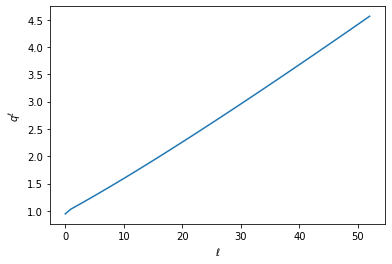

In [ ]:
compute_q_star(1,.3,show_hist=True)

[ 0.95652258  1.95652258  2.93364557  3.91472435  4.89823995  5.88344653
  6.86991386  7.85736752  8.84561994  9.83453622 10.82401558 11.81398035
 12.8043692  13.7951327  14.78623033 15.77762835 16.76929836 17.76121616
 18.75336092 19.74571459 20.73826138 21.73098739 22.72388032 23.7169292
 24.71012422 25.70345656 26.69691824 27.69050203 28.68420135 29.67801019
 30.67192304 31.66593483 32.66004091 33.65423697 34.648519   35.64288332
 36.63732647 37.63184524 38.62643663 39.62109783 40.61582622 41.61061932
 42.60547481 43.6003905  44.59536433 45.59039436 46.58547875 47.58061575
 48.57580371 49.57104106 50.56632632 51.56165807 52.55703497]
<class 'numpy.float64'>


-5

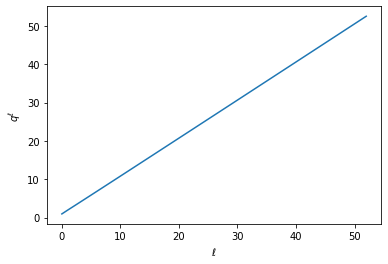

In [ ]:
compute_q_star(1,1,show_hist=True)

[1.07869733e+00 1.01078697e+02 2.01075393e+02 3.01073049e+02
 4.01071134e+02 5.01069474e+02 6.01067989e+02 7.01066633e+02
 8.01065378e+02 9.01064203e+02 1.00106310e+03 1.10106205e+03
 1.20106104e+03 1.30106008e+03 1.40105916e+03 1.50105827e+03
 1.60105742e+03 1.70105659e+03 1.80105578e+03 1.90105500e+03
 2.00105423e+03 2.10105349e+03 2.20105277e+03 2.30105206e+03
 2.40105136e+03 2.50105069e+03 2.60105002e+03 2.70104937e+03
 2.80104873e+03 2.90104810e+03 3.00104748e+03 3.10104688e+03
 3.20104628e+03 3.30104569e+03 3.40104511e+03 3.50104454e+03
 3.60104398e+03 3.70104343e+03 3.80104288e+03 3.90104234e+03
 4.00104181e+03 4.10104128e+03 4.20104077e+03 4.30104025e+03
 4.40103975e+03 4.50103924e+03 4.60103875e+03 4.70103826e+03
 4.80103777e+03 4.90103729e+03 5.00103682e+03 5.10103635e+03
 5.20103588e+03]
<class 'numpy.float64'>


-5

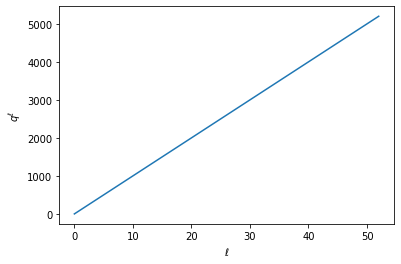

In [ ]:
compute_q_star(1,10,show_hist=True)

**Task:** Let's compute the fixed points for different values of $\sigma_w$ and $\sigma_b$.

In [ ]:
nx, ny = (300,300)
x = np.linspace(.1, 1.5, nx)
y = np.linspace(.1, 1.5, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=100, clip=20, err_val=-10)

# zs = np.zeros(xv.shape)
# for i in tqdm(range(nx)):
#  for j in range(ny):
#    zs[i,j] = compute_q_star(xv[i,j], yv[i,j], tau=0.5, max_steps=6, clip=5)

<class 'numpy.ndarray'>


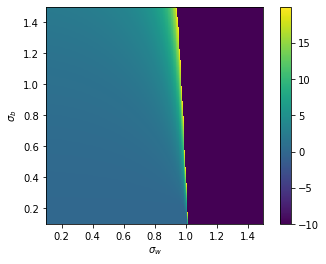

In [ ]:
h = plt.pcolormesh(x, y, zss)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()
plt.show()

# Part 2. Compute the edge of chaos curve.

The edge of chaos have the following formula for hard-thresholding.
$$\chi_1 = \sigma^2_w \int_\mathbb{R} \left(\phi'(\sqrt{q^*} z) \right)^2 \, \gamma(dz) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q^*}}\right) = 1$$

We may therefore simulate the edge of chaos by fixing $q^*$, then find $\sigma_w$ then $\sigma_b$. Again, we may compute this edge of chaos curve numerically (using Scipy integrator) or using `norm.sf`.

We note that $V'_\phi(q) = 2\sigma^2_w \tilde{\Phi}\left(\frac{\tau}{\sqrt{q}} \right)$ as well.

**Task:** Implement a function which takes in $q^*$ and compute the theoretical $\sigma_w$ and $\sigma_b$.

In [ ]:
def get_sw_sb_from_q_star_numerical(qstar, tau=tau, check=False, min_qstar=None, max_qstar=None):
  def d_soft(z,tau=tau):
    return 1 - (np.abs(z) < tau)

  def chi_1_integrand(z, qstar, tau=tau):
    return normal(z)*(d_soft(np.sqrt(qstar)*z, tau=tau))**2
    
  def calc_sw(qstar, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: chi_1_integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(np.divide(1,integral))

  def calc_sb(qstar, sw, tau=tau):
    integral, _ = sp.integrate.quad(lambda z: integrand(z,qstar,tau=tau), -np.inf, np.inf)
    return np.sqrt(qstar - (sw**2)*integral)
  
  c_sw = calc_sw(qstar)
  c_sb = calc_sb(qstar, c_sw)

  if check:
    if max_qstar == None:
      max_qstar = 2
    qstar_eval = np.linspace(0, max_qstar, 500)
    plt.plot(qstar_eval, length_map_analytical(qstar_eval, c_sw, c_sb), label="length map")
    plt.plot(qstar_eval, qstar_eval, label="identity")
    plt.xlabel("q[l]")
    plt.ylabel("q[l+1]")
    plt.legend()
    print(float(length_map_analytical(qstar, c_sw, c_sb)), float(compute_q_star(c_sw, c_sb)))
  return (c_sw, c_sb)

In [ ]:
def get_sw_sb_from_q_star_analytical(q, tau=tau, check=False, min_qstar=None, max_qstar=None):
  ratio = tau/np.sqrt(q)
  sw2 = 0.5/norm.sf(ratio)
  sb2 = q - 2*sw2*((q + tau**2) * norm.sf(ratio) - np.sqrt(q) * tau * normal(ratio))
  output = np.sqrt(np.array([sw2, sb2]))

  if check:
    if max_qstar == None:
      max_qstar = 2
    qstar_eval = np.linspace(0, max_qstar, 500)
    plt.plot(qstar_eval, length_map_analytical(qstar_eval, output[0], output[1]), label="length map")
    plt.plot(qstar_eval, qstar_eval, label="identity")
    plt.xlabel("q[l]")
    plt.ylabel("q[l+1]")
    plt.legend()
    print(float(length_map_analytical(q, output[0], output[1])), float(compute_q_star(output[0], output[1])))
  return output

In [ ]:
qstar_eval = np.logspace(0, 1.53, 100)

sigma_ws_numerical = []
sigma_bs_numerical = []

for qstar in tqdm(qstar_eval):
  sw, sb = get_sw_sb_from_q_star_numerical(qstar, tau=1)
  sigma_ws_numerical.append(sw)
  sigma_bs_numerical.append(sb)

 35%|███▌      | 35/100 [00:00<00:01, 61.04it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  if __name__ == '__main__':
100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


In [ ]:
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=1)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

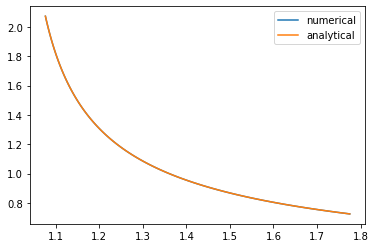

In [ ]:
plt.plot(sigma_ws_numerical, sigma_bs_numerical)
plt.plot(sigma_ws_analytical, sigma_bs_analytical)
plt.legend(["numerical", "analytical"])

<class 'numpy.float64'>
5.000000000000001 3.998262087802855


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


array([1.10225833, 0.89837174])

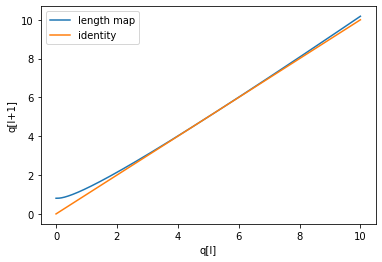

In [ ]:
get_sw_sb_from_q_star_analytical(5, tau=tau, check=True, max_qstar=10)

# Combining all analysis

<class 'numpy.ndarray'>


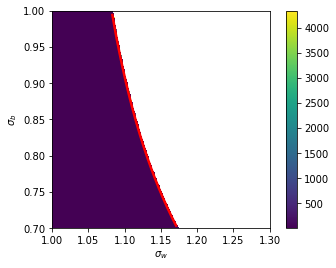

In [ ]:
nx, ny = (300,300)
x = np.linspace(1.0, 1.3, nx)
y = np.linspace(0.7, 1.0, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
zss = compute_q_star(xv, yv, tau=0.5, max_steps=500, clip=5000, err_val=float("nan"))
qstar_eval = np.logspace(.32, .86, 1000)
sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval)
sigma_ws_analytical = sigma_ws_bs_analytical[0]
sigma_bs_analytical = sigma_ws_bs_analytical[1]

plt.pcolormesh(x, y, zss)
plt.plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
plt.axis('scaled')
plt.xlabel("$\sigma_w$")
plt.ylabel("$\sigma_b$")
plt.colorbar()

# fig.subplots_adjust(right=1.2)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(im, cax=cbar_ax)
plt.show()

## Let's try running through the analysis for multiple $\tau$.

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


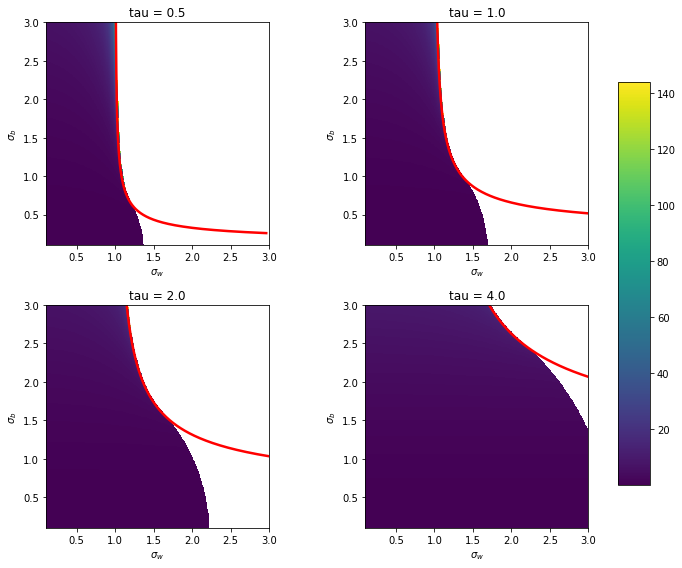

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
taus = np.array([[0.5, 1], [2,4]])
nx, ny = (400,300)
x = np.linspace(.1, 3, nx)
y = np.linspace(.1, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
qstar_eval = np.logspace(-1, 4, 1000)

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  zss = compute_q_star(xv, yv, tau=taus[i][j], max_steps=100, clip=200, err_val=float("nan"))
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  im = ax[i][j].pcolormesh(x,y,zss)
  # fig.colorbar(im, ax=ax, shrink=0.9)
  ax[i][j].plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
  ax[i][j].axis('scaled')
  ax[i][j].set_xlim([0.1, 3])
  ax[i][j].set_ylim([0.1, 3])
  ax[i][j].set_xlabel("$\sigma_w$")
  ax[i][j].set_ylabel("$\sigma_b$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


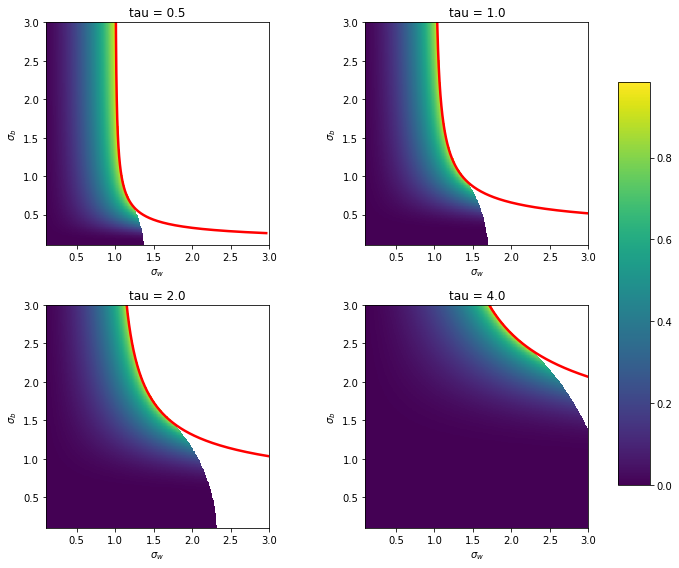

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,8))
taus = np.array([[0.5, 1], [2,4]])
nx, ny = (400,300)
x = np.linspace(.1, 3, nx)
y = np.linspace(.1, 3, ny)
xv, yv = np.meshgrid(x, y, indexing='xy')
qstar_eval = np.logspace(-1, 4, 1000)

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  zss = compute_q_star(xv, yv, tau=taus[i][j], max_steps=1000, clip=4000, err_val=float("nan"))
  chi1 = 2 * xv**2 * norm.sf(taus[i][j]/np.sqrt(zss))
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  im = ax[i][j].pcolormesh(x,y,chi1)
  # fig.colorbar(im, ax=ax, shrink=0.9)
  ax[i][j].plot(sigma_ws_analytical, sigma_bs_analytical, color="red", linewidth=2.5)
  ax[i][j].axis('scaled')
  ax[i][j].set_xlim([0.1, 3])
  ax[i][j].set_ylim([0.1, 3])
  ax[i][j].set_xlabel("$\sigma_w$")
  ax[i][j].set_ylabel("$\sigma_b$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()  

# Part 3. Does the length map converges if initialised along the edge of chaos curve?

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


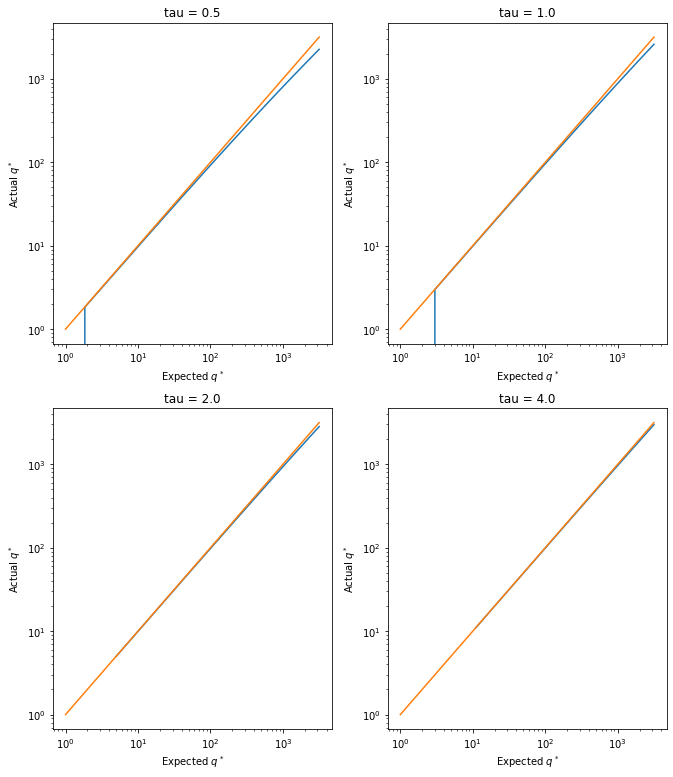

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,13))
qstar_eval = np.logspace(0, 3.5, 500)
taus = np.array([[0.5, 1], [2,4]])

for i, j in [(0,0), (0,1), (1,0), (1,1)]:
  sigma_ws_bs_analytical = get_sw_sb_from_q_star_analytical(qstar_eval, tau=taus[i][j])
  sigma_ws_analytical = sigma_ws_bs_analytical[0]
  sigma_bs_analytical = sigma_ws_bs_analytical[1]
  z = compute_q_star(sigma_ws_analytical, sigma_bs_analytical, tau=taus[i][j], max_steps=1000, clip=10000, err_val=-100)
  ax[i][j].plot(qstar_eval, z)
  ax[i][j].plot(qstar_eval, qstar_eval)
  ax[i][j].set_xscale("log")
  ax[i][j].set_yscale("log")
  ax[i][j].set_xlabel(r"Expected $q^*$")
  ax[i][j].set_ylabel(r"Actual $q^*$")
  ax[i][j].set_title(f"tau = {taus[i][j]}")

Practical simulations suggested yes, but convergence seems to be rather slow.

# Part 4. Computing the correlation map along the edge of chaos curve

The formula is 
$$R(\rho; q_{11}, q_{12}) = \sigma^2_w \int_\mathbb{R} \int_\mathbb{R} \phi(u_1(z_1, z_2)) \phi(u_2(z_1, z_2)) \, \gamma(dz_1) \gamma(dz_2) + \sigma^2_b.$$
where 
$$u_1(z_1, z_2) = \sqrt{q_{11}} z_1, \quad u_2(z_1, z_2) = \sqrt{q_{22}} \left[ \rho z_1 + \sqrt{1-\rho^2} z_2 \right].$$

In [ ]:
def correlation_map(prev, q11, q22=None, activation_func=None, sigma_b=None, sigma_w=None, q_conv=False, err_tol=1e-3, *args, **kwargs):
  if q22 == None:
    q22=q11
  
  if activation_func == None:
    def activation_func(x,tau=tau): 
      return soft_thresholding_numpy(x, tau=tau)
  
  if sigma_b == None or sigma_w == None:
    sw_sb = get_sw_sb_from_q_star_analytical(qstar, tau=tau)
    sigma_w = sw_sb[0]
    sigma_b = sw_sb[1]

  def u1(q11, z1):
    return( np.sqrt( q11 ) * z1 )

  def u2(prev, q22, z1, z2):
    res = np.sqrt( q22 ) * ( prev * z1 + np.sqrt( 1 - prev ** 2 ) * z2 )
    return( res )

  def integrator( z1, z2 ):
    inner = activation_func( u1( q11, z1 ), tau ) * activation_func( u2( prev, q22, z1, z2 ), tau )
    integrand = inner * np.exp( - ( z1 ** 2 + z2 **2 ) / 2 )
    return( integrand )

  z1_range = np.inf
  z2_range = np.inf
  integral = scipy.integrate.dblquad( integrator, -z1_range, z1_range, -z2_range, z2_range )[ 0 ] / (2*np.pi)
  res = (sigma_w ** 2) * integral + (sigma_b ** 2)

  new_q11 = length_map_analytical(q11, sw=sigma_w, sb=sigma_b, tau=tau)
  new_q22 = length_map_analytical(q22, sw=sigma_w, sb=sigma_b, tau=tau)

  if q_conv == True and (abs(new_q11 - q11) > err_tol or abs(new_q22 - q22) > err_tol):
    warnings.warn("length map does not converge, so the result may not be valid.")
    print(q11, new_q11)

  return( res/np.sqrt(new_q11 * new_q22) )

In [ ]:
correlation_map(0.9, .3, q_conv=True)

0.3 2.292403750816179


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: length map does not converge, so the result may not be valid.


0.9958038016438197

In [ ]:
get_sw_sb_from_q_star_analytical(10)

array([1.06943183, 1.0839329 ])

In [ ]:
rho_eval = np.linspace(0,1,30)
corr_outputs = [[], [], [], []]
q_eval = [.5, 1, 2, 4]

for i in range(4):
  print(q_eval[i])
  for rho in tqdm(rho_eval):
    corr = correlation_map(rho, q_eval[i])
    corr_outputs[i].append(corr)

0.5


100%|██████████| 30/30 [03:11<00:00,  6.37s/it]


1


 23%|██▎       | 7/30 [00:33<02:10,  5.69s/it]/usr/local/lib/python3.7/dist-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  **opt)
100%|██████████| 30/30 [03:25<00:00,  6.85s/it]


2


100%|██████████| 30/30 [03:42<00:00,  7.42s/it]


4


 37%|███▋      | 11/30 [01:16<02:37,  8.28s/it]

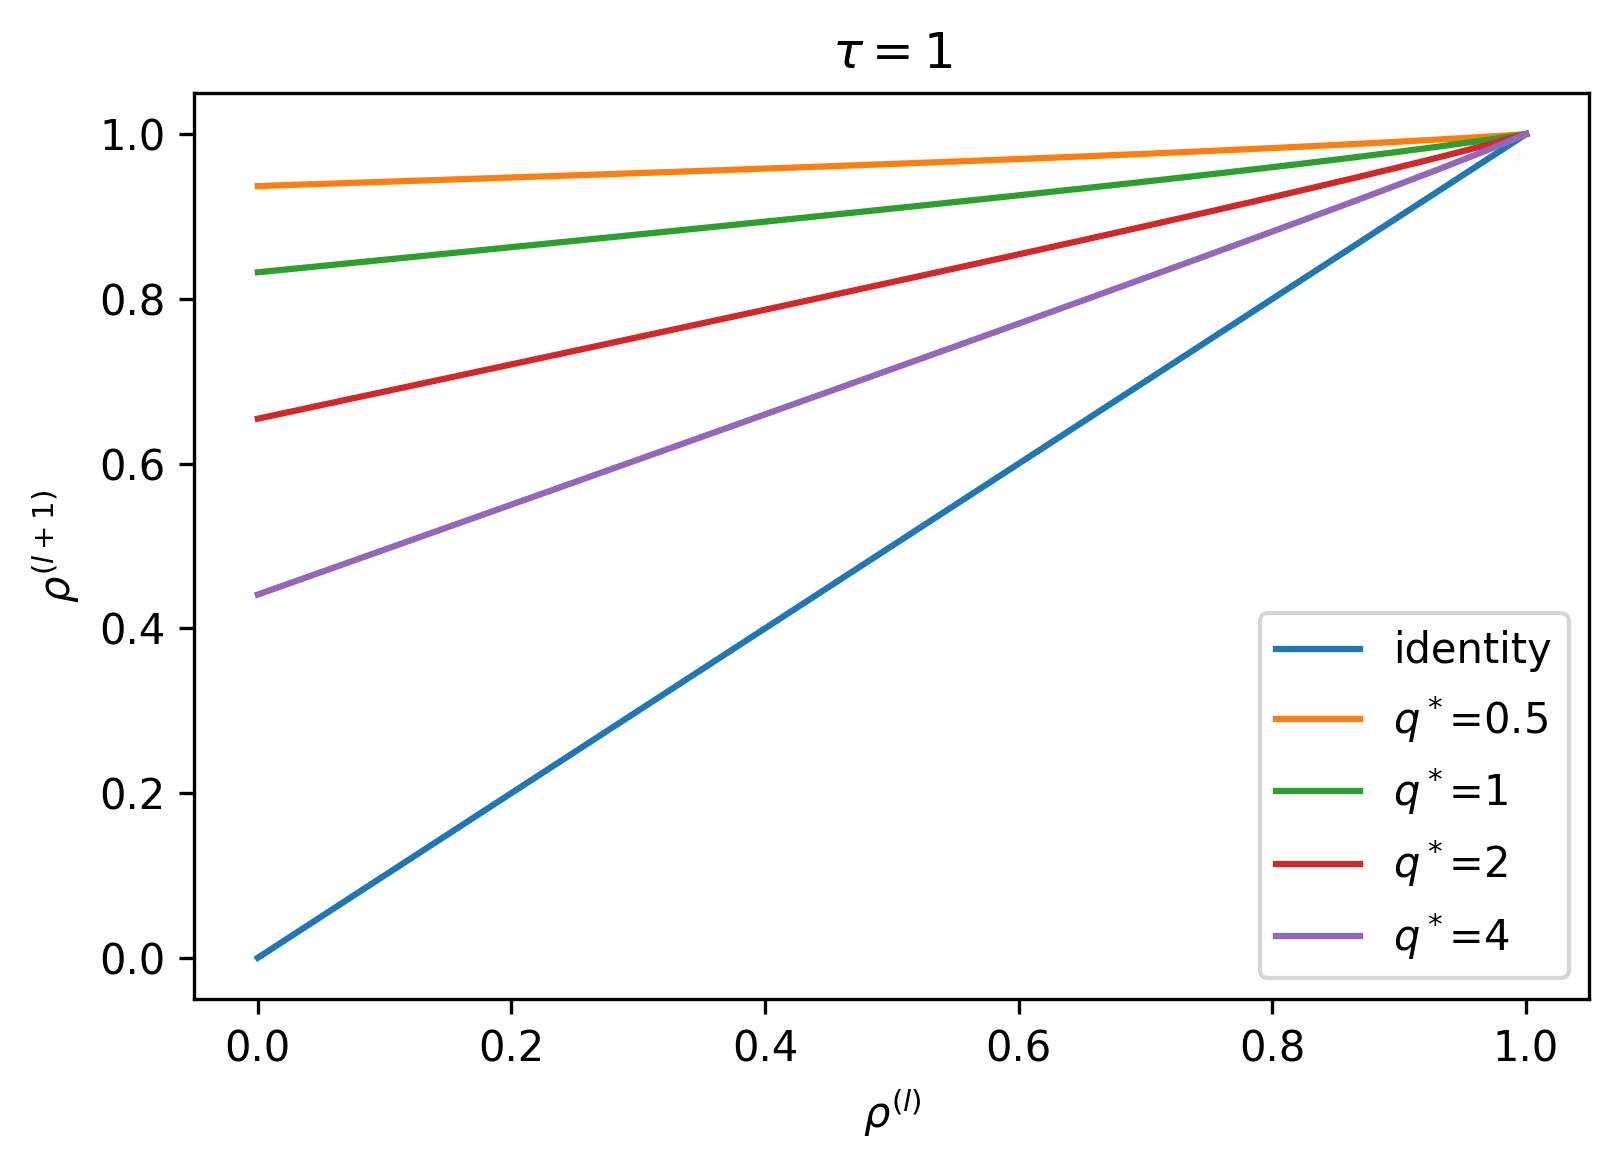

In [ ]:
fig, ax = plt.subplots()
fig.set_dpi(300)

ax.plot(rho_eval, rho_eval, label="identity")

for i in range(4):
  ax.plot(rho_eval, np.array(corr_outputs[i]), label=f"$q^*$={q_eval[i]}")

ax.set_xlabel(r"$\rho^{(l)}$")
ax.set_ylabel(r"$\rho^{(l+1)}$")
ax.set_title(r"$\tau = 1$")
ax.legend()